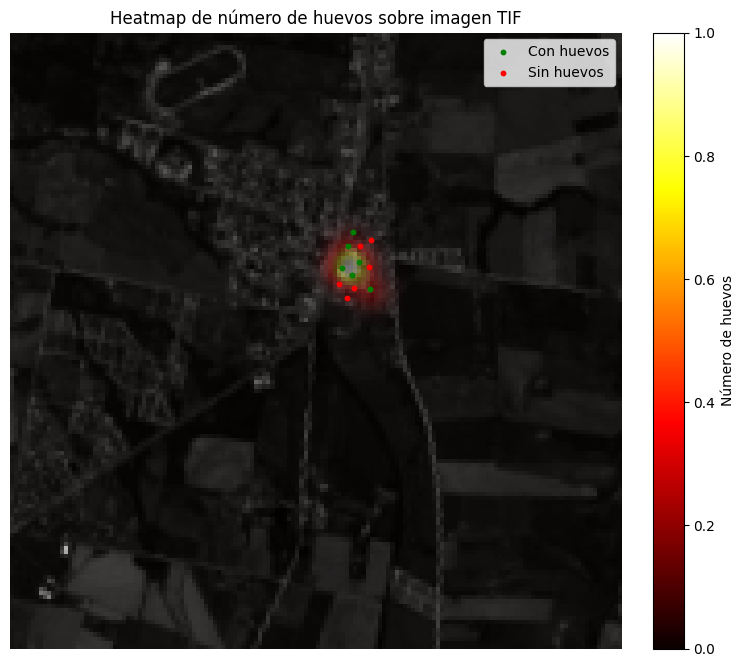

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import subprocess

archivo_b4 = subprocess.run(f"ls ../ImagenesRecortadas/*B4.TIF", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True).stdout.strip("\n")

with rasterio.open(archivo_b4) as src:
    # Leer la imagen TIF
    tif_image = src.read(1)  # Lee la banda 1 (puedes ajustar según la banda que necesites)
    # Obtener transformación y CRS (sistema de referencia de coordenadas)
    transform = src.transform
    crs = src.crs

# Paso 2: Cargar los datos desde el archivo CSV
# Reemplaza 'datos.csv' con el nombre de tu archivo CSV
df = pd.read_csv('../data/datos_ovitrampas_transformados.csv')

df = df[df['fecha'] == '14/02/2018']

df.to_csv("data_filtrada.csv", index=False)


# Obtener las columnas relevantes
longitudes = df['x'].values
latitudes = df['y'].values
nro_huevos = df['nro_huevos'].values

x_min, y_min, x_max, y_max = src.bounds

# Crear un histograma 2D (heatmap)
heatmap, xedges, yedges = np.histogram2d(latitudes, longitudes, bins=src.shape, weights=nro_huevos, range=[[y_min, y_max], [x_min, x_max]])
heatmap = gaussian_filter(heatmap, sigma=3) 

# Normalizar el heatmap entre 0 y 1 para mejorar la visualización
if heatmap.max() != heatmap.min():
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
else:
    heatmap = heatmap / heatmap.max()  # Manejo del caso cuando todos los valores son iguales


fig, ax = plt.subplots(figsize=(10, 8))

# Mostrar la imagen TIF
ax.imshow(tif_image, cmap='gray', extent=[x_min, x_max, y_min, y_max])

# Mostrar el heatmap sobre la imagen TIF
heatmap_plot = ax.imshow(heatmap, cmap='hot', alpha=0.3, extent=[x_min, x_max, y_min, y_max], origin='lower')
# Puntos donde nro_huevos es mayor a cero
df_con_huevos = df[df['nro_huevos'] != 0]
ax.scatter(df_con_huevos['x'], df_con_huevos['y'], color='green', s=10, label='Con huevos')

# Puntos donde nro_huevos es nulo
df_sin_huevos = df[df['nro_huevos'] == 0]
ax.scatter(df_sin_huevos['x'], df_sin_huevos['y'], color='red', s=10, label='Sin huevos')


norm = Normalize(vmin=heatmap.min(), vmax=heatmap.max())
sm = ScalarMappable(cmap='hot', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Número de huevos', fraction=0.046, pad=0.04)


ax.set_title('Heatmap de número de huevos sobre imagen TIF')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.axis('off')  
ax.legend()

# Mostrar la gráfica
plt.show()

In [117]:
nro_huevos

array([32,  0,  0,  0, 50, 36, 36,  0,  0,  0, 21,  1])

/home/justo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


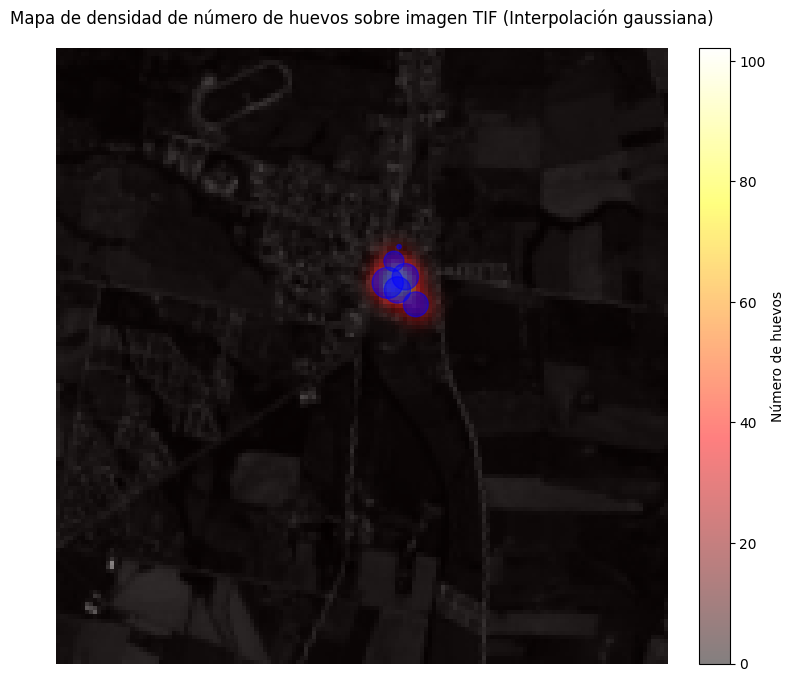

In [1]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# Función gaussiana
def gaussian(x, y, x0, y0, sigma):
    return np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

# Obtener el archivo TIF de la banda B4
archivo_b4 = subprocess.run(f"ls ../ImagenesRecortadas/*B4.TIF", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True).stdout.strip("\n")

# Abrir el archivo TIF
with rasterio.open(archivo_b4) as src:
    # Leer la imagen TIF
    tif_image = src.read(1)  # Lee la banda 1 (puedes ajustar según la banda que necesites)
    # Obtener transformación y CRS (sistema de referencia de coordenadas)
    transform = src.transform
    crs = src.crs
    # Obtener límites de la imagen
    x_min, y_min, x_max, y_max = src.bounds
    # Resolución de píxeles en la imagen
    pixel_width, pixel_height = src.res

# Cargar los datos desde el archivo CSV
df = pd.read_csv('../data/datos_ovitrampas_transformados.csv')

# Filtrar datos por una fecha específica o cualquier otro criterio necesario
# Ejemplo: Filtrar por una fecha específica (ajustar según tu CSV)
df = df[df['fecha'] == '14/02/2018']

# Obtener las columnas relevantes del CSV
latitudes = df['y'].values
longitudes = df['x'].values
nro_huevos = df['nro_huevos'].values

# Calcular la densidad de huevos por píxel interpolando con función gaussiana
density_map = np.zeros_like(tif_image, dtype=np.float64)

# Iterar sobre cada punto de datos y aplicar la interpolación gaussiana
sigma = 3  # Parámetro de dispersión de la gaussiana
for lat, lon, eggs in zip(latitudes, longitudes, nro_huevos):
    # Convertir coordenadas a índices de píxeles
    col, row = int((lon - x_min) / pixel_width), int((lat - y_min) / pixel_height)
    
    # Aplicar la función gaussiana alrededor del punto (row, col)
    y, x = np.indices(density_map.shape)
    density_map += eggs * gaussian(x, y, col, row, sigma)

# Invertir el density_map en el eje vertical para corregir la inversión
density_map = np.flipud(density_map)

# Aplanar density_map para usarlo como sizes (opcional)
sizes = np.ravel(density_map) * 10  # Ajustar el multiplicador para el tamaño de los puntos
sizes = 10 * nro_huevos
# Crear la figura y el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Mostrar la imagen TIF en escala de grises
ax.imshow(tif_image, cmap='gray', extent=[x_min, x_max, y_min, y_max])

# Mostrar el density_map como una superposición de calor
cbar = ax.imshow(density_map, cmap='hot', alpha=0.5, extent=[x_min, x_max, y_min, y_max])

# Configurar colorbar sin normalización
cbar = fig.colorbar(cbar, ax=ax, label='Número de huevos', fraction=0.046, pad=0.04)

# Graficar puntos con tamaño proporcional a la densidad de huevos (opcional)
ax.scatter(longitudes, latitudes, s=sizes, color='blue', alpha=0.5)

ax.set_title('Mapa de densidad de número de huevos sobre imagen TIF (Interpolación gaussiana)')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.axis('off')

# Mostrar la gráfica
plt.show()